# CPSC 330 Lecture 22

Outline:

- 👋
- **Turn on recording**
- Announcements
- Ethics, bias, fairness, AI safety (30 min)
- Feature importances for computer vision (10 min)
- Break (5 min)
- Ethics activity (20 min)
- Bonus material on combining tables (time-permitting)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import utils
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

from skimage.segmentation import mark_boundaries

In [3]:
plt.rcParams['font.size'] = 16

## Announcements

- hw9 due Monday 11:59pm
- Next class will be a guest lecture on ethics by Sina Fazelpour (who may be here today!)

## Attribution

Thanks to Ed Knorr for sharing materials from [DSCI 541](https://github.com/UBC-MDS/DSCI_541_priv-eth-sec). 

## Ethics for ML (30 min)

- Today I will attempt to say a bit about ethics for applied ML.
- Warning: I do not know much about these topics.

- Privacy and ethics issues around data have been in the news a lot lately. E.g. the [Cambridge Analytica scandal](https://en.wikipedia.org/wiki/Facebook%E2%80%93Cambridge_Analytica_data_scandal)
  - There's even a [Netflix movie](https://www.netflix.com/ca/title/80117542) about it.
- We've seen eyebrow-raising results in previous lectures, e.g. inherently biased word embeddings.

There seem to be various problems here:

- Ethics
- Bias
- Fairness
- AI safety
- Privacy
- and more.

I will talk through a bunch of articles and resources.

#### Bias, intolerance

- Bias: we have similar problems as we had with NLP.
- These models are trained from huge datasets, we don't exactly know how they work.
- See, e.g. [this paper](https://arxiv.org/pdf/1711.11443.pdf), Figure 8.
- See [this article](https://www.theregister.com/2020/07/01/mit_dataset_removed/) about hte "80 Million Tiny Images" dataset.
  - Often datasets are collected without manual curation.
- Discussion: how could this sort of bias affect peoples' lives negatively?

<br><br><br><br><br><br>

Where does bias come from?

- Biases could come from data (if data only has certain groups in certain situations).
- Biases could come from labels (if they were generated by humans, or not!).
- Biases could come from learning method (this is harder to get at).

#### Strange results

- See [this 2019 paper](https://arxiv.org/pdf/1809.04729.pdf) (from UBC), Figure 1.

#### AI safety and adversarial examples

- See [this 2015 paper](https://arxiv.org/pdf/1412.6572.pdf), Figure 1, for whitebox software attack.
- See [this 2018 paper](https://arxiv.org/pdf/1712.09665.pdf), Figure 1, for whitebox **physical** attack. 
- If the input is a $1000\times 1000$ image, the input space is so big.
  - it is hard to imagine all the possible perturbations, so some of them work out.

#### Fake news and deepfakes

- You may have heard of [deepfakes](https://en.wikipedia.org/wiki/Deepfake).
- See [this 2020 article](https://www.theguardian.com/technology/2020/jan/13/what-are-deepfakes-and-how-can-you-spot-them).
  - which led me to this [hilarious 2019 deepfake video](https://www.youtube.com/watch?v=4GdWD0yxvqw&feature=emb_logo). 

#### Environmental impact

- Current methods require:
  – A lot of data.
  – A lot of time to train.
  – Many training runs to do hyper-parameter optimization.
- See [this 2019 paper](https://arxiv.org/pdf/1906.02243.pdf), Table 1, for the CO$_2$ emissions of training a sophisticated deep learning model.
  - Entire training procedure emits 5 times more CO2 than lifetime emission of a car, including making the car


### Case study: criminal machine learning

- Calling BS video 5.5 on ["Criminal Machine Learning"](https://www.youtube.com/watch?v=rga2-d1oi30&list=PLPnZfvKID1Sje5jWxt-4CSZD7bUI4gSPS&index=27) (pun intended, presumably?) discussed a case of predicting whether someone is a criminal based on their face.
- There is also a text case study [here](https://callingbullshit.org/case_studies/case_study_criminal_machine_learning.html) in which they critique (criticize?) the work.
- They show some sample training data:

![](https://callingbullshit.org/case_studies/img/criminals.png)

- Your prediction algorithm is only as good (or as bad) as your traning data.
- Possible problems: 
  - Wearing a white shirt and jacket vs. other clothes (turns out the authors removed these).
  - Facial expressions (e.g. smiling vs. frowning) - this is what the Calling BS folks think is happening.
  - Cropping, lighting, etc.
- It would be interesting to try something like SHAP or LIME here to highlight what areas of the image are important.

- But the Calling BS post also raises a fundamentally different type of problem:
  - What if the criminal justice system was biased in the first place?
  - E.g. it tends to convict less attractive faces.
  - Then the algorithm will learn to emulate this.
- It would be challenging to get around this problem.
- How can our algorithm be "better" (less biased) than humans if humans labeled the data?!

Let's take a step back here: 

- How much "signal" do we expect to get from faces anyway? 
  - I would say, maybe a tiny bit better than random. 
- The authors claim 90% accuracy. That sounds too good to be true. Per the Calling BS videos, if it sounds too good to be true, it probably is.
- Even if the results seem to make sense, do the risks outweigh the benefits?

#### Suggested strategies: experimental set-up problems

- Ask yourself, are my results too good to be true?
- Use baselines like `DummyClassifier` and `DummyRegressor`.
- Look at feature importances.
- Manually look at some of the correct/incorrect predictions (or very low/high error for regression).
- Try making changes or perturbations (e.g. different train/validation folds) and check if your results are robust.
- When you are done, think carefully about your confidence (or _credence_, see lecture 21) regarding any claims you make.

#### Suggested strategies: ethical/fairness issues

- Bias usually comes from the data, not the algorithm. Think carefully about how the training data were collected.
- Familiarize yourself with how your model will be used.
- Ask yourself who might be affected by this model in deployment. 

## Feature importances for computer vision (10 min)


- See [this 2018 blog post](https://medium.com/@jrzech/what-are-radiological-deep-learning-models-actually-learning-f97a546c5b98) on diagnosing cardiomegaly (enlarged heart).
  - The model learns that the portable scanner is used on sicker patients who cannot go to the hospital.
- See the README of the [LIME repo](https://github.com/marcotcr/lime).
- It can shade the images based on importance, like the above.
- Also works for other data types.

Extra dependency: LIME

```
pipe install lime
```

In [4]:
import lime
from lime import lime_image

In [5]:
resnet = ResNet50(weights='imagenet')

Note the important distinction between the choice of architecture (in this case, `ResNet50`) and the choice of dataset (in this case, ImageNet).

#### ImageNet

- [ImageNet](http://www.image-net.org/) is an image dataset that became a very popular benchmark in the field ~10 years ago. 
- [Wikipedia article](https://en.wikipedia.org/wiki/ImageNet)
- There are 14 million images and 1000 classes

Here's my graduation photo from undergrad:

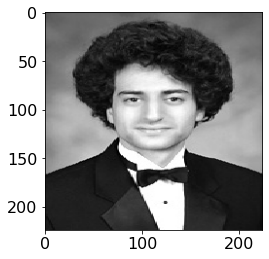

In [6]:
img_path_bowtie = 'img/gelbart-michael-adam.jpg'
img_bowtie = load_img(img_path_bowtie, target_size=(224, 224))
plt.imshow(img_bowtie);

In [7]:
x_bowtie = img_to_array(img_bowtie).astype('double')
x_bowtie = np.expand_dims(x_bowtie, axis=0)

In [8]:
x_bowtie = preprocess_input(x_bowtie) # this modifies the array inplace???

In [9]:
preds_bowtie = resnet.predict(x_bowtie)
decode_predictions(preds_bowtie, top=3)[0]

[('n02883205', 'bow_tie', 0.99401516),
 ('n03838899', 'oboe', 0.002141438),
 ('n03110669', 'cornet', 0.0010458563)]

The following code is adapted from [one of the LIME example notebooks](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb):

In [10]:
explainer_bowtie = lime_image.LimeImageExplainer()

The next cell is a bit slow (about 1 min on my laptop):

In [11]:
np.random.seed(1)
explanation_bowtie = explainer_bowtie.explain_instance(x_bowtie[0], resnet.predict,
                                                       top_labels=5, hide_color=0, num_samples=1000);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


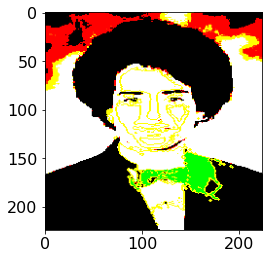

In [12]:
temp_bowtie, mask_bowtie = explanation_bowtie.get_image_and_mask(explanation_bowtie.top_labels[0], 
                                                                 positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp_bowtie, mask_bowtie));

- The image doesn't look quite right because of `preprocess_input` above.
- I tried to get around this in various ways, for quite a while, but I couldn't figure it out.
  - Tried wrapped `resnet.predict` in a function that does the preprocessing.
  - Tried to invert `preprocess_input`.
  - Tried to understand what LIME is actually doing inside some of the functions.
  - Gave up.

OK, let's see why it thought my office was a prison!!

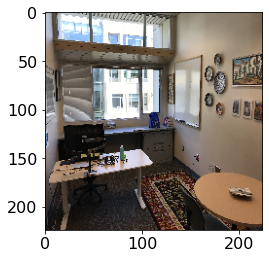

In [13]:
img_path_office = 'img/office.jpg'
img_office = load_img(img_path_office, target_size=(224, 224))
plt.imshow(img_office);

In [14]:
x_office = img_to_array(img_office)
x_office = np.expand_dims(x_office, axis=0)

In [15]:
x_office = preprocess_input(x_office)

In [16]:
preds_office = resnet.predict(x_office)
decode_predictions(preds_office, top=3)[0]

[('n04005630', 'prison', 0.32494283),
 ('n03179701', 'desk', 0.07232616),
 ('n04239074', 'sliding_door', 0.045325305)]

In [17]:
explainer_office = lime_image.LimeImageExplainer()

In [18]:
# this is a bit slow again
explanation_office = explainer_office.explain_instance(x_office[0].astype('double'), resnet.predict,
                                                       top_labels=5, hide_color=0, num_samples=1000);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


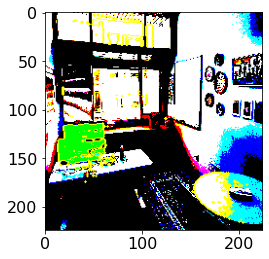

In [19]:
temp_office, mask_office = explanation_office.get_image_and_mask(explanation_office.top_labels[0], 
                                                                 positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp_office, mask_office));

Huh! This doesn't seem very helpful... I think there's a bug here or the preprocessing issue again.

## Break (5 min)

REMINDER TO RESUME RECORDING!

## Ethics activity (20 min)

**Background info.** University admissions offices are known to use ML (often through a specialized 3rd party company) as part of their admissions process. Here are some things they might want to predict (this is a mix of [things](https://www.nytimes.com/interactive/2019/09/10/magazine/college-admissions-paul-tough.html) I've [read](https://www.washingtonpost.com/business/2019/10/14/colleges-quietly-rank-prospective-students-based-their-personal-data/) and some speculation):

- What is this student's chance of accepting an offer from us?
- How much financial aid do we need to give this student in order for them to accept?
- How well might the student do academically at our institution? How likely are they to graduate within 6 years?
- Aside from tuition: how likely would the student be to donate in the future? In short, what is their [customer lifetime value](https://en.wikipedia.org/wiki/Customer_lifetime_value)? (We briefly mentioned this in lecture 17 on customer churn!)

**Your task:** Watch [this short advertisement](https://www.youtube.com/watch?v=MjTZM7VQDzQ) for CBE, a [product](https://www.capturehighered.com/cbe-marketing-automation/) that helps universities "engage with prospective students" using a "behavioral intelligence platform". Then, in today's Google Doc, answer at least **one** of the following questions:

1. What sort of information could CBE capture that might be useful to feed into an ML algorithm like this?
2. What are some possible ethical or fairness concerns about using this information?
3. What sort of information about a student _does_ seem reasonable to use as part of the university admissions process?
4. What if we're using the same information but having humans make the decisions, instead of ML? Does that change anything?

BTW there are clearly some serious _privacy_ issues here, but let's try focus on the ethics/fairness issues.
<br><br><br>

(optional) Some notes, for those who are interested:

- After making predictions for each student, they may try to optimize for a balanced class, e.g. a mix of "asset types" to balance out risks. This is reminiscent of [portfolio optimization](https://en.wikipedia.org/wiki/Portfolio_optimization) in finance.
- I suspect the situation is a bit better in Canada where most universities, and all top universities, are public. In the US private universities and colleges are a huge industry, and there are even a lot of for-profit post-secondary institutions.
- I suspect the vast majority of prospective students are unaware that this information is being collected. Worse, some of these trackers might track activity _outside_ of the school website.

## If we have time left

We can do the "combining multiple tables" materials as bonus.